Membres du groupe : CHAHBAOUI Mohammed, KARATAS Musab, HITCHON Thomas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

base_path = Path('./')

X_train = np.load(base_path / 'train_images.npy').astype(np.float32)
Y_train = np.load(base_path / 'train_labels.npy')

X_test = np.load(base_path / 'test_public_images.npy').astype(np.float32)
Y_test = np.load(base_path / 'test_public_labels.npy')

classes, counts = np.unique(Y_train, return_counts=True)
counts_test = np.unique(Y_test, return_counts=True)[1]

classes_names = [
    "Avoine d'hiver",
    "Avoine de printemps",
    "Blé tendre d'hiver",
    "Blé tendre de printemps",
    "Colza d'hiver",
    "Luzerne déshydratée",
    "Luzerne",
    "Mélange de légumineuses et graminées",
    "Maïs",
    "Maïs ensilage",
    "Orge d'hiver",
    "Orge de printemps",
    "Prairie permanente - herbe",
    "Prairie permanente - ressources fourragères ligneuses",
    "Prairie en rotation longue",
    "Pomme de terre de consommation",
    "Prairie temporaire",
    "Soja",
    "Tournesol",
    "Triticale d'hiver"
]

# Aplatir les données pour les forêts et regressions
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1) 

# Standardisation pour la régression logistique 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Poids des classes pour gérer le déséquilibre 
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(Y_train),y=Y_train)
class_weights = dict(zip(np.unique(Y_train), class_weights))

# Forêt d'Arbres Décisionnels Aléatoires

## Modèle 1

In [2]:
tree_clf = RandomForestClassifier(
        n_estimators=100, 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        class_weight=class_weights
    )

tree_clf.fit(X_train_flattened, Y_train)

Y_pred = tree_clf.predict(X_test_flattened)

# Evaluation
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(Y_test, Y_pred, target_names=classes_names))

Accuracy: 0.71
                                                       precision    recall  f1-score   support

                                       Avoine d'hiver       0.00      0.00      0.00        11
                                  Avoine de printemps       0.00      0.00      0.00         4
                                   Blé tendre d'hiver       0.79      0.70      0.74       781
                              Blé tendre de printemps       0.86      0.97      0.91       108
                                        Colza d'hiver       0.94      0.98      0.96       225
                                  Luzerne déshydratée       0.93      0.69      0.79        39
                                              Luzerne       0.56      0.28      0.37        36
                 Mélange de légumineuses et graminées       0.43      0.58      0.49        84
                                                 Maïs       0.73      0.59      0.65       116
                                  

c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

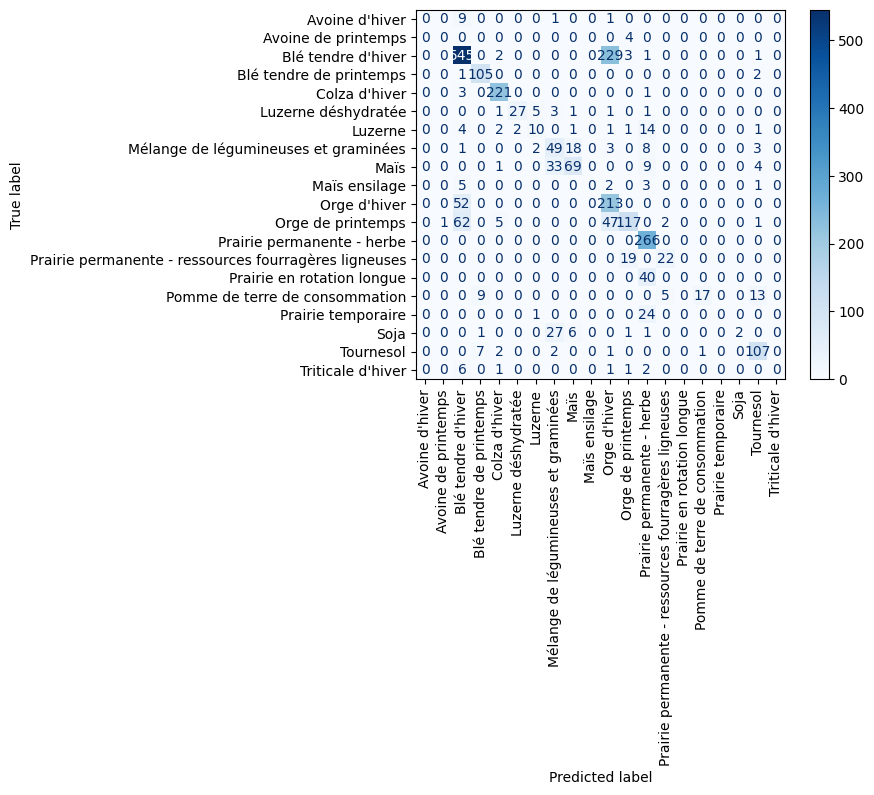

In [3]:
# Affichage Matrice de confusion (modèle 1)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

## RandomizedSearchCV

pour trouver la meilleur combinaison d'hyperparamètres

In [3]:

from sklearn.utils import shuffle
fraction = 0.3
X_train_small, Y_train_small = shuffle(X_train_flattened, Y_train, random_state=42)
X_train_small = X_train_small[:int(len(X_train_flattened) * fraction)]
Y_train_small = Y_train_small[:int(len(Y_train) * fraction)]

param_dist = {
    'max_depth': [10, None],
    'min_samples_leaf': [1, 5]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight=class_weights),
    param_distributions=param_dist,
    n_iter=5,
    scoring='f1_weighted',
    cv=3, 
    n_jobs=-1
)

random_search.fit(X_train_small, Y_train_small)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'min_samples_leaf': 1, 'max_depth': 10}
Best score: 0.7948041832234104


## Modèle 2

In [2]:
rf2 = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=4,
    class_weight=class_weights,       
)

rf2.fit(X_train_flattened, Y_train)


Y_pred = rf2.predict(X_test_flattened)

# Evaluation
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(Y_test, Y_pred, target_names=classes_names))

Accuracy: 0.65
                                                       precision    recall  f1-score   support

                                       Avoine d'hiver       0.29      0.18      0.22        11
                                  Avoine de printemps       0.00      0.00      0.00         4
                                   Blé tendre d'hiver       0.90      0.50      0.64       781
                              Blé tendre de printemps       0.87      0.97      0.92       108
                                        Colza d'hiver       0.91      0.97      0.94       225
                                  Luzerne déshydratée       0.83      0.64      0.72        39
                                              Luzerne       0.29      0.42      0.34        36
                 Mélange de légumineuses et graminées       0.49      0.49      0.49        84
                                                 Maïs       0.66      0.62      0.64       116
                                  

c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# Affichage Matrice de confusion  model = rf2
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

# Régression Logistique

## Modèle 1 sans pénalisation l2

c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.62


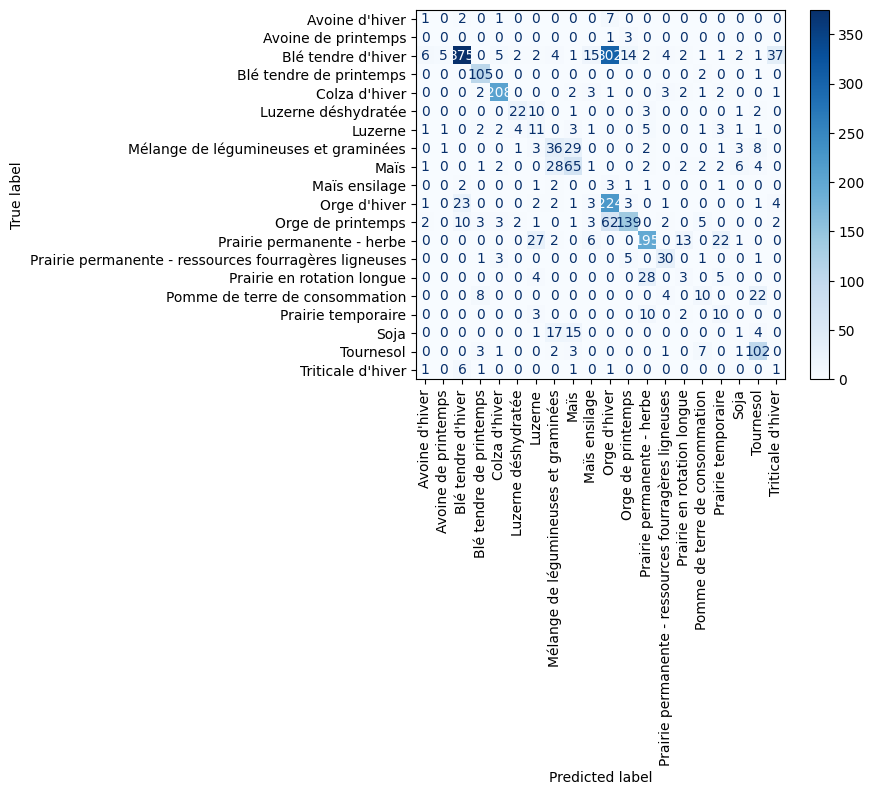

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.08      0.09      0.08        11
     Class 1       0.00      0.00      0.00         4
     Class 2       0.90      0.48      0.63       781
     Class 3       0.83      0.97      0.90       108
     Class 4       0.92      0.92      0.92       225
     Class 5       0.71      0.56      0.63        39
     Class 6       0.17      0.31      0.22        36
     Class 7       0.39      0.43      0.41        84
     Class 8       0.53      0.56      0.55       116
     Class 9       0.00      0.00      0.00        11
    Class 10       0.37      0.85      0.52       265
    Class 11       0.84      0.59      0.69       235
    Class 12       0.79      0.73      0.76       266
    Class 13       0.67      0.73      0.70        41
    Class 14       0.12      0.07      0.09        40
    Class 15       0.33      0.23      0.27        44
    Class 16       0.21      0.40      0.28        25
    

In [8]:
log_reg2 = LogisticRegression(class_weight=class_weights, solver='lbfgs', multi_class='multinomial', penalty=None)
log_reg2.fit(X_train_scaled, Y_train)

Y_pred = log_reg2.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

print("Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=[f"Class {i}" for i in range(len(classes))]))


## Modèle 2

c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.63


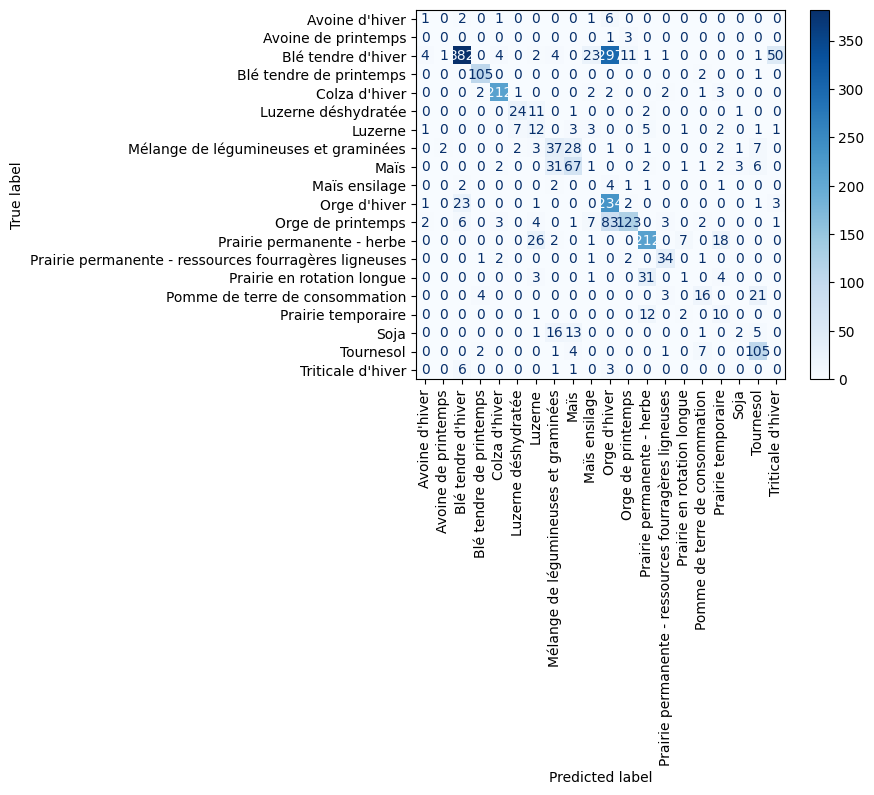

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.11      0.09      0.10        11
     Class 1       0.00      0.00      0.00         4
     Class 2       0.91      0.49      0.64       781
     Class 3       0.92      0.97      0.95       108
     Class 4       0.95      0.94      0.94       225
     Class 5       0.71      0.62      0.66        39
     Class 6       0.19      0.33      0.24        36
     Class 7       0.39      0.44      0.42        84
     Class 8       0.57      0.58      0.57       116
     Class 9       0.00      0.00      0.00        11
    Class 10       0.37      0.88      0.52       265
    Class 11       0.87      0.52      0.65       235
    Class 12       0.79      0.80      0.80       266
    Class 13       0.77      0.83      0.80        41
    Class 14       0.08      0.03      0.04        40
    Class 15       0.52      0.36      0.43        44
    Class 16       0.24      0.40      0.30        25
    

In [7]:
lr_clf2 = LogisticRegression(max_iter=500, class_weight=class_weights, solver='lbfgs', multi_class='multinomial', penalty='l2', C=0.01)
hist_lr2 = lr_clf2.fit(X_train_scaled, Y_train)

Y_pred = lr_clf2.predict(X_test_scaled)

# Evaluation
accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

print("Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=[f"Class {i}" for i in range(len(classes))]))

## GridSearchCV

In [2]:
from sklearn.utils import shuffle
fraction = 0.1
X_train_small, Y_train_small = shuffle(X_train_flattened, Y_train, random_state=42)
X_train_small = X_train_small[:int(len(X_train_flattened) * fraction)]
Y_train_small = Y_train_small[:int(len(Y_train) * fraction)]

param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l2', 'none']
}

grid = GridSearchCV(LogisticRegression(max_iter=10, solver='lbfgs', class_weight=class_weights), param_grid, cv=3)
grid.fit(X_train_small, Y_train_small)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the numb

Best parameters: {'C': 0.01, 'penalty': 'l2'}
Best score: 0.48804792816768866


c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Convolutional Neural Network

In [2]:
# Transposition des données
X_train = X_train.transpose(0, 1, 3, 4, 2) 
X_test = X_test.transpose(0, 1, 3, 4, 2) 

# Normalisation min max des pixels
X_train_norm = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test_norm = (X_test - np.min(X_train)) / (np.max(X_train) - np.min(X_train))


## Modèle 1

In [6]:
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(10, 32, 32, 3)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(20, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrainement
history = model.fit(X_train_norm, Y_train, validation_data=(X_test_norm, Y_test), epochs=15, batch_size=32, class_weight=class_weights)

# Evaluation
loss, accuracy = model.evaluate(X_test_norm, Y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")
y_prob = model.predict(X_test_norm)
y_pred = y_prob.argmax(axis=-1)

print("Classification Report:")
print(classification_report(Y_test, y_pred, target_names=[f"Class {i}" for i in range(len(classes))]))

c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 143ms/step - accuracy: 0.1969 - loss: 2.5069 - val_accuracy: 0.3756 - val_loss: 1.7749
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.4513 - loss: 1.5707 - val_accuracy: 0.4232 - val_loss: 1.5943
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.4740 - loss: 1.4058 - val_accuracy: 0.4384 - val_loss: 1.6967
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - accuracy: 0.5013 - loss: 1.2531 - val_accuracy: 0.4296 - val_loss: 1.5867
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.5329 - loss: 1.2911 - val_accuracy: 0.3536 - val_loss: 2.0118
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 45s 141ms/step - accuracy: 0.5570 - loss: 1.1199 - val_accuracy: 0.4260 - val_loss: 1.5132
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 111ms/step - accuracy: 0.5929 - loss: 1.0546 - val_accuracy: 0.5580 - val_loss: 1.1966
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.5846 - loss: 1.

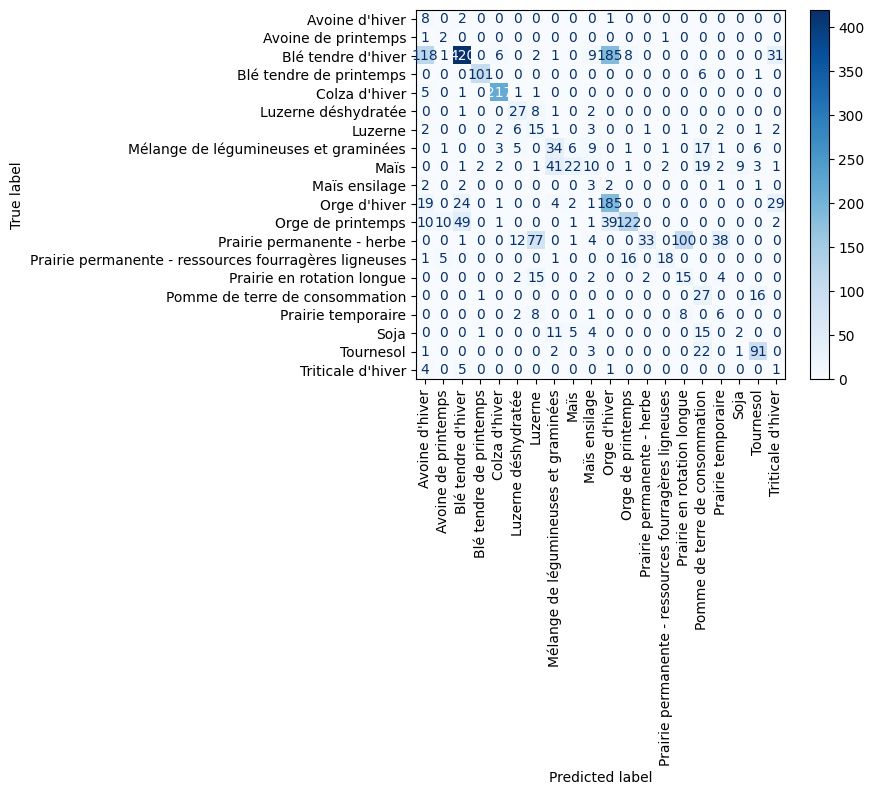

In [8]:
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

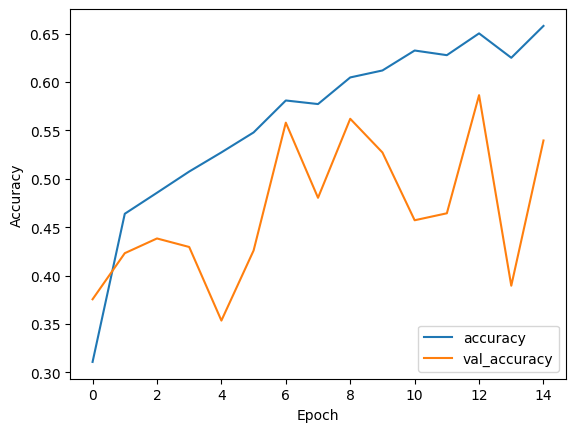

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

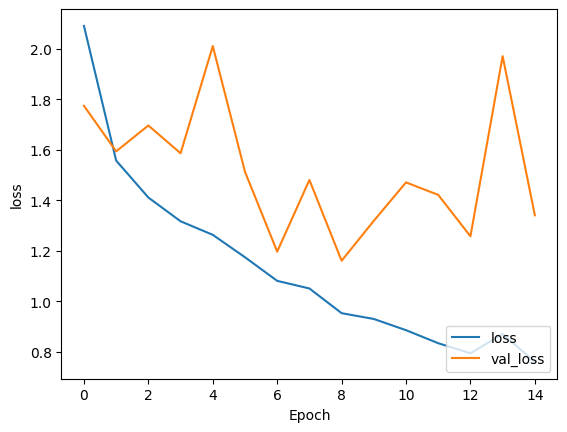

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

## Modèle 2

In [3]:
model2 = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(10, 32, 32, 3), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),

    Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(20, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Entrainement
history2 = model2.fit(X_train_norm, Y_train, validation_data=(X_test_norm, Y_test), epochs=20, batch_size=32, callbacks=[callback], class_weight=class_weights)

# Evaluation
loss, accuracy = model2.evaluate(X_test_norm, Y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")
y_prob = model2.predict(X_test_norm)
y_pred = y_prob.argmax(axis=-1)

c:\Users\raoul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.2860 - loss: 4.2576 - val_accuracy: 0.0412 - val_loss: 4.0248
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.4185 - loss: 2.6776 - val_accuracy: 0.3388 - val_loss: 3.0913
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step - accuracy: 0.4355 - loss: 2.2792 - val_accuracy: 0.3488 - val_loss: 3.0644
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 117ms/step - accuracy: 0.4952 - loss: 1.8486 - val_accuracy: 0.3180 - val_loss: 2.7333
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 132ms/step - accuracy: 0.5082 - loss: 1.6924 - val_accuracy: 0.3852 - val_loss: 2.0564
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - accuracy: 0.5067 - loss: 1.6774 - val_accuracy: 0.3836 - val_loss: 2.2233
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.5263 - loss: 1.5629 - val_accuracy: 0.5100 - val_loss: 1.5303
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.5258 - loss: 1.47

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.17      0.36      0.24        11
     Class 1       0.00      0.00      0.00         4
     Class 2       0.94      0.19      0.32       781
     Class 3       0.94      0.95      0.94       108
     Class 4       0.99      0.66      0.79       225
     Class 5       0.64      0.77      0.70        39
     Class 6       0.16      0.33      0.21        36
     Class 7       0.26      0.33      0.29        84
     Class 8       0.47      0.70      0.56       116
     Class 9       0.01      0.45      0.02        11
    Class 10       0.55      0.70      0.61       265
    Class 11       0.72      0.31      0.43       235
    Class 12       0.82      0.69      0.75       266
    Class 13       1.00      0.07      0.14        41
    Class 14       0.07      0.07      0.07        40
    Class 15       0.00      0.00      0.00        44
    Class 16       0.09      0.64      0.15        25
    

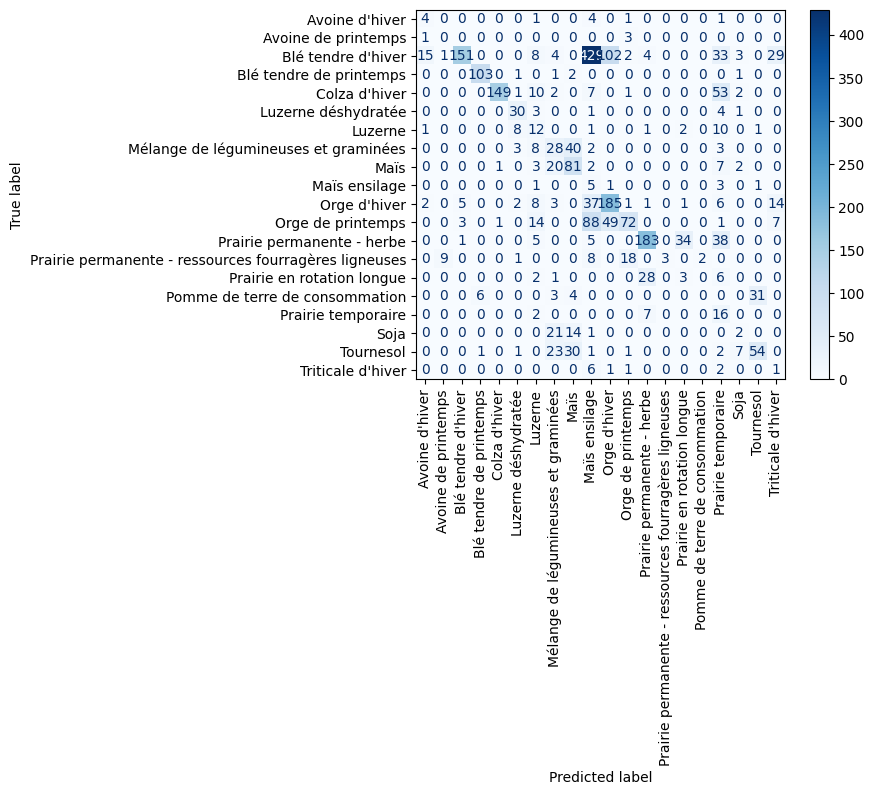

In [4]:
print("Classification Report:")
print(classification_report(Y_test, y_pred, target_names=[f"Class {i}" for i in range(len(classes))]))

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

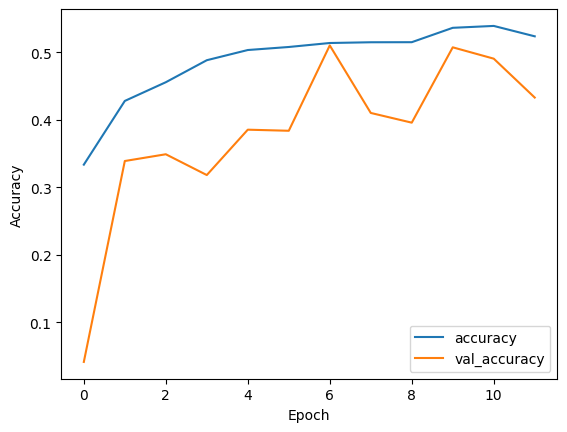

In [ ]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

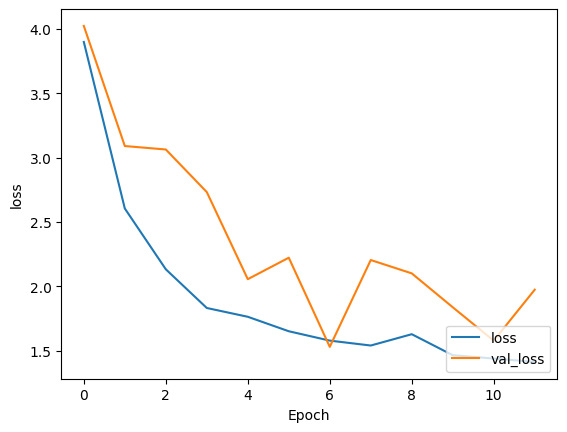

In [ ]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')